# Overview

## Imports and image loading

In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image
import PIL.ImageOps
import numpy as np
from scipy import ndimage
from skimage.util import random_noise

In [2]:
cam = Image.open('cameraman.tif', mode='r').convert(mode="L")
lena = Image.open('lena.tiff', mode='r').convert(mode="L")
grayscale = Image.open('Grayscale.tif', mode='r').convert(mode="L")

In [3]:
def gaussian_noise(im):
    noisy = random_noise(np.array(im), mode='gaussian', var=0.002)
    return Image.fromarray(np.uint8(noisy*255))

def salt_pepper_noise(im):
    noisy = random_noise(np.array(im), mode='s&p', amount=0.05)
    return Image.fromarray(np.uint8(noisy*255))

def speckle_noise(im):
    noisy = random_noise(np.array(im), mode='speckle', var=0.04)
    return Image.fromarray(np.uint8(noisy*255))

In [25]:
def MSE(im1, im2):
    assert im1.size == im2.size and im1.mode == im2.mode
  
    im1_data = np.array(im1, dtype=np.int32).flatten()
    im2_data = np.array(im2, dtype=np.int32).flatten()
    
    M = len(im1_data)
    
    MSE = np.power(np.subtract(im1_data, im2_data), 2).sum() / M
    return MSE

def PSNR(im1, im2):
    assert im1.size == im2.size and im1.mode == im2.mode
    mse = MSE(im1, im2)
    if mse == 0:
        return math.inf
    return 10 * math.log10(65025.0 / mse) # 255^2 = 65025

def plot_histogram(im, title):
    im_hist = im.histogram()
    plt.bar([i for i in range(256)], im_hist)
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

# Noise Reduction in the Spatial Domain

PSNR between Lena and noisy Lena: 26.966845085608018


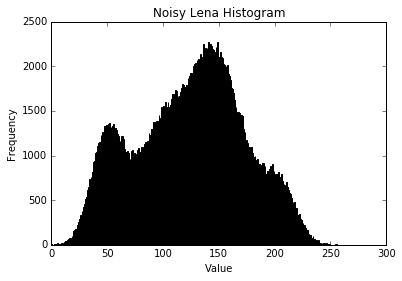

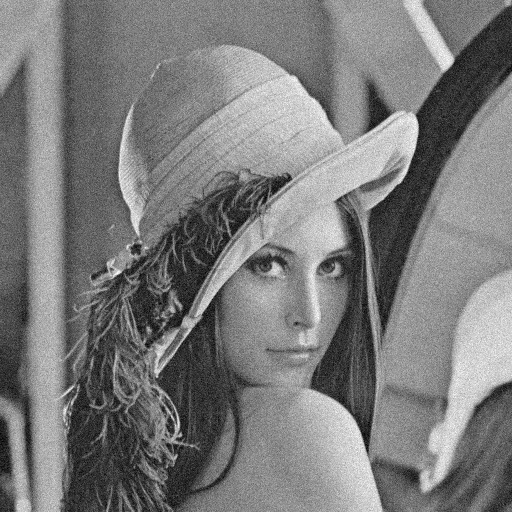

In [26]:
%matplotlib inline
noisy_lena = gaussian_noise(lena)
print("PSNR between Lena and noisy Lena: " + str(PSNR(lena, noisy_lena)))

plot_histogram(noisy_lena, "Noisy Lena Histogram")

noisy_lena

### noisy lena convolved with 3x3 averaging filter

3x3 averaging filter:
PSNR between Lena and averaged Lena: 31.82448328828835



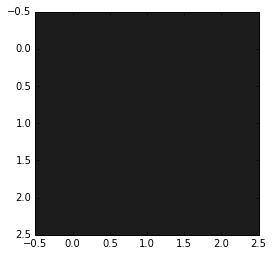

In [54]:
avg_3_3 = (1/9)*np.ones([3,3])

print("3x3 averaging filter:")
imshow(Image.fromarray(avg_3_3 *255))

noisy_lena_avg1 = Image.fromarray(ndimage.convolve(np.array(noisy_lena), avg_3_3), 'L')

print("PSNR between Lena and averaged Lena: " + str(PSNR(lena, noisy_lena_avg1)) + "\n")

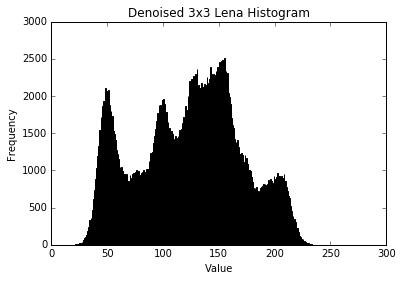

In [64]:
plot_histogram(noisy_lena_avg1, "Denoised 3x3 Lena Histogram")

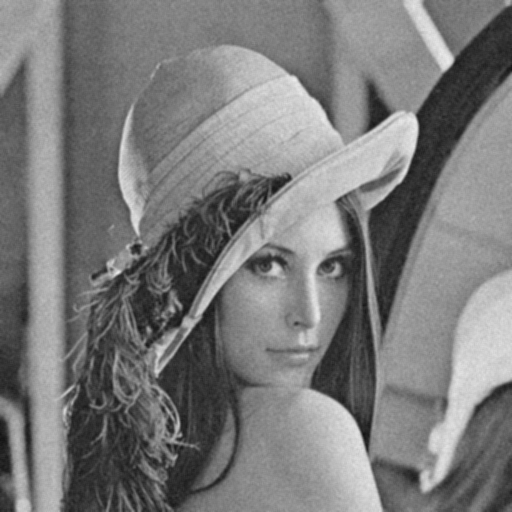

In [53]:
noisy_lena_avg1

### noisy lena convolved with 7x7 averaging filter

7x7 averaging filter:
PSNR between Lena and averaged Lena: 27.387645689358706



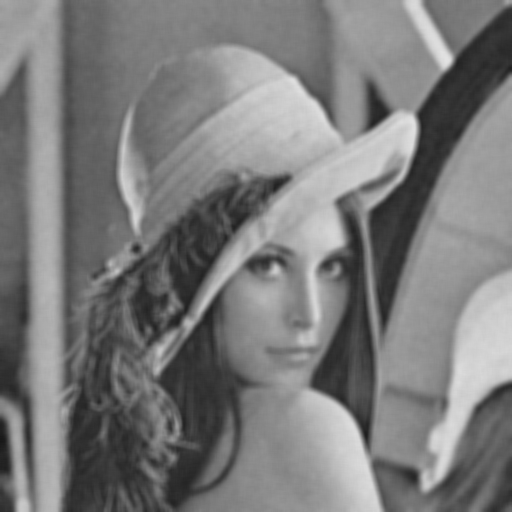

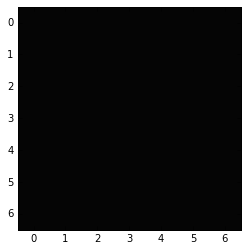

In [61]:
avg_7_7 = (1/(7*7))*np.ones([7,7])

print("7x7 averaging filter:")
imshow(Image.fromarray(avg_7_7 *255))

noisy_lena_avg2 = Image.fromarray(ndimage.convolve(np.array(noisy_lena), avg_7_7), 'L')

print("PSNR between Lena and averaged Lena: " + str(PSNR(lena, noisy_lena_avg2)) + "\n")

noisy_lena_avg2

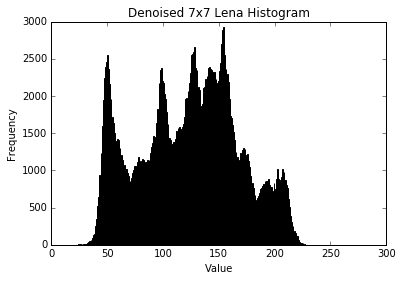

In [63]:
plot_histogram(noisy_lena_avg2, "Denoised 7x7 Lena Histogram")

### Gaussian 7x7 filter

PSNR between Lena and Gaussian Lena: 31.729589906748956



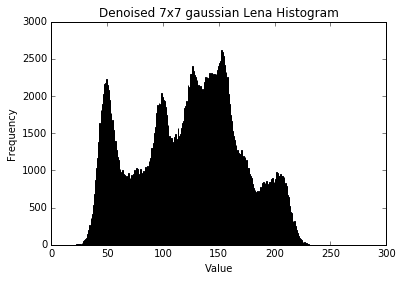

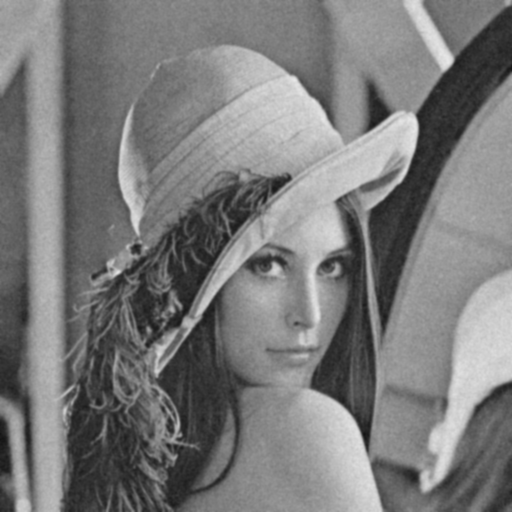

In [72]:
gaus_denoised = Image.fromarray(ndimage.filters.gaussian_filter(np.array(noisy_lena), 1,))
print("PSNR between Lena and Gaussian Lena: " + str(PSNR(lena, gaus_denoised)) + "\n")
plot_histogram(gaus_denoised, "Denoised 7x7 gaussian Lena Histogram")

gaus_denoised